In [3]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error

from models.fcmodel import FCModel
from utils.exp_utils import load_mnist, np_to_torch, speckle_pred

# ==========================================================================
exp_data_dir = "../data/experiment"

# print(os.path.exists(exp_data_dir))
exp_collected = os.path.join(
    exp_data_dir,
    "collect/Mnist+Rand_pix28x28_image(1000+1000)x2_sig2500_4wave_newPD.npz",
)
exp_target = os.path.join(
    exp_data_dir, "target/Mnist+Rand_pix28x28_image(1000+1000)x2.npz"
)
# ==========================================================================

# Y_mnist Shape: (1000, 10000)
# X_mnist Shape: (1000, 784)
X_mnist, Y_mnist = load_mnist(target_path=exp_target, collect_path=exp_collected)
# X_rand, Y_rand = load_random(target_path=exp_target, collect_path=exp_collected)
# print("X_rand max, min:", X_rand.max(), X_rand.min())
# inv_X Shape: (784, 1000)
# inv_X = np.linalg.pinv(X_rand, rcond=1e-14)
# print("inv_X maxmin:", inv_X.max(), inv_X.min())
# S_0 Shape: (784, 10000)
# S_0 = np.matmul(inv_X, Y_rand)
S_0 = speckle_pred(target_path=exp_target, collect_path=exp_collected, alpha=1.0)
S_0_tensor = np_to_torch(S_0).float()
# S_0_tensor_std = standardize(S_0_tensor)
# (1000, 784)
X_mnist_tensor = np_to_torch(X_mnist).float()

# (1000, 10000)
Y_mnist_tensor = np_to_torch(Y_mnist).float()


# CUDAが使えるかどうかの判定
if torch.cuda.is_available():
    device = "cuda"
# MPSが使えるかどうかの判定（Appleシリコン環境など）
elif torch.backends.mps.is_available():
    device = "mps"
# 上記がどちらも使えない場合はCPU
else:
    device = "cpu"

print("Using device:", device)
######################################################
# Training function
######################################################

loss_total = []
reconstructed_total = []
# num_images = Y_mnist_tensor.shape[0]
num_images = 10
learning_rate = 0.001
num_epochs = 10000
S_0_tensor = S_0_tensor.to(device)
print("S max, S min:", S_0_tensor.max(), S_0_tensor.min())
print("Y_mnist max, min:", Y_mnist_tensor.max(), Y_mnist_tensor.min())
model = FCModel(input_size=10000, hidden_size=1024, output_size=784).to(device)
for i in range(num_images):
    # initialize model and params
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    y_i = Y_mnist_tensor[i].unsqueeze(0)  # (1, 10000)
    y_i = y_i.to(device)
    print("y_i shape:", y_i.shape)
    # y_i = standardize(y=y_i)
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # output shape: (1, 784)
        output = model(y_i)

        # Y_dash(1, 10000) = output(1, 784) * S_0_tensor(784, 10000)
        # print(output.shape, S_0_tensor.shape)
        Y_dash = torch.mm(output, S_0_tensor)
        loss = criterion(Y_dash, y_i)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 1000 == 0:
            print(
                f"Image {i}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.14f}"
            )
    model.eval()
    with torch.no_grad():
        reconstucted_target = model(y_i).squeeze(0)
        print(reconstucted_target.shape)
        reconstructed_total.append(reconstucted_target.cpu().numpy())

reconstructed_total = np.vstack(reconstructed_total)
print(reconstructed_total.shape)
mse_val = mean_squared_error(X_mnist[:num_images, :], reconstructed_total)
print(mse_val)
# print(len(reconstructed_total))


Y_mnist Shape: (1000, 10000)
X_mnist Shape: (1000, 784)
Test MSE: 7.619563767520335e-06
S_est shape: (784, 10000)
Using device: mps
S max, S min: tensor(0.0035, device='mps:0') tensor(-0.0037, device='mps:0')
Y_mnist max, min: tensor(0.1728) tensor(0.0048)
y_i shape: torch.Size([1, 10000])
Image 10, Epoch [1000/10000], Loss: 0.00003491421012
Image 10, Epoch [2000/10000], Loss: 0.00003389389531
Image 10, Epoch [3000/10000], Loss: 0.00003291166286
Image 10, Epoch [4000/10000], Loss: 0.00003188476330
Image 10, Epoch [5000/10000], Loss: 0.00003099730384
Image 10, Epoch [6000/10000], Loss: 0.00002882093031
Image 10, Epoch [7000/10000], Loss: 0.00002827815115
Image 10, Epoch [8000/10000], Loss: 0.00002724048682
Image 10, Epoch [9000/10000], Loss: 0.00002653146294
Image 10, Epoch [10000/10000], Loss: 0.00002676937766
torch.Size([784])
(1, 784)
1.1194956457438678


In [4]:
import matplotlib.pyplot as plt

def image_display(
    j,
    xx,
    yy,
    size=28,
):
    print("MSE =", mean_squared_error(xx, yy))
    # print("PSNR =", psnr_calc(xx, yy))
    # print("SSIM =", calculate_average_ssim(xx, yy, num_images=10))
    fig = plt.figure(figsize=(4, 4 * j))
    for i in range(j):
        ax1 = fig.add_subplot(j, 2, i * 2 + 1)
        ax2 = fig.add_subplot(j, 2, i * 2 + 2)

        ax1.set_title("Target_image")
        ax2.set_title("Reconstruction")

        ax1.imshow(xx[i, :].reshape(size, size), cmap="gray", vmin=-1, vmax=1)
        ax2.imshow(yy[i, :].reshape(size, size), cmap="gray")
    plt.show()

MSE = 1.1194956457438678


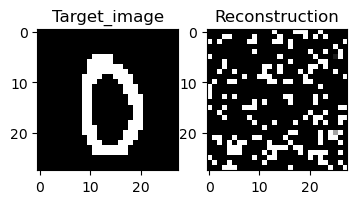

In [5]:
image_display(1, X_mnist[10:11, :], reconstructed_total, size=28)